# Most general form of cross-validation
---

This provides no personalization, and still avoids the issue of using a subject's future data for prediction.

In [10]:
%pylab --no-import-all inline

from os import path
import sys

import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = path.join("..", 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport visualization.visualize
from visualization.visualize import modified_bland_altman_plot

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
file = path.join("..", "data", "processed", "df.csv")
df_orig = pd.read_csv(file, index_col=0)

In [12]:
NUMBER_OF_DAYS = 10
df = df_orig[df_orig.L_PREOVULATION > NUMBER_OF_DAYS]  # No use predicting backward in time.
temp_measurements = ["TEMP" + str(i + 1) for i in range(NUMBER_OF_DAYS)]
features = [*temp_measurements]

In [13]:
X = df[features]
y = df.L_PREOVULATION
grouping = df.ID

In [14]:
mlpr = MLPRegressor(random_state=1337, hidden_layer_sizes=(100, 20)) # RandomForestRegressor(n_estimators=200, random_state=1337)
imp = Imputer(strategy='median')
pipeline = Pipeline([('imp', imp), ('mlp', mlpr)])

In [15]:
cv = GroupKFold(n_splits=10)

In [16]:
y_pred = cross_val_predict(pipeline, X, y, 
                           cv=cv, groups=grouping,
                           verbose=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished


In [17]:
mean_squared_error(y_pred=y_pred, y_true=y)

15.484448327919608

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_pred=y_pred, y_true=y)

2.8160705551929803

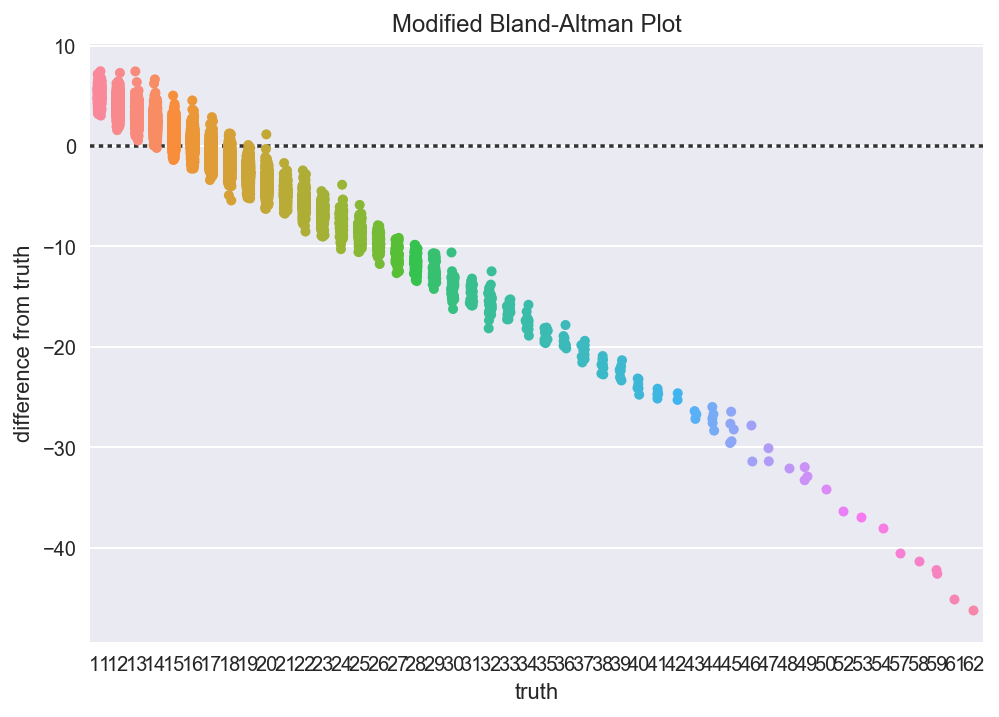

In [10]:
modified_bland_altman_plot(y_pred, y);

## Discussion
---

This model is extremely simple. Our features are only the first six temperatures of the cycle and the participant's age. With it, we achieve a MSE of about 18, which is not that far from the Bortot paper's 15. And with the first ten days, we get about 16.5. In terms of use case, they are about equal to the Bortot result.

In [11]:
df.L_PERIOD.median()

5.0

Now, the median period length is 5, which means that we are really using measurements of BBT during the period to determine the day of ovulation.

Since this model has no personalization at all, it's exciting to see how well a personalized model will do.